# Nutrition Paradox: A Global View on Obesity and Malnutrition 

In [1]:
# import necesarry package

import requests
import pandas as pd
import pycountry
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector as db

In [2]:
# Obesity

url_obesity_adults = "https://ghoapi.azureedge.net/api/NCD_BMI_30C"
url_obesity_children = "https://ghoapi.azureedge.net/api/NCD_BMI_PLUS2C"

# Malnutrition

url_malnutrition_adults = "https://ghoapi.azureedge.net/api/NCD_BMI_18C"
url_malnutrition_children = "https://ghoapi.azureedge.net/api/NCD_BMI_MINUS2C"

In [3]:
# define a function to load url data

def load_who_data_url(url):
    response = requests.get(url)
    data = response.json()['value']
    df = pd.json_normalize(data)
    return df

In [4]:
# load 4 dataset

# Obesity
df_obese_adults = load_who_data_url(url_obesity_adults)
df_obese_children = load_who_data_url(url_obesity_children)

# Malnutrition
df_underweight_adults = load_who_data_url(url_malnutrition_adults)
df_thin_children = load_who_data_url(url_malnutrition_children)

In [5]:
# Add age group column

df_obese_adults['age_group'] = 'Adult'
df_obese_children['age_group'] = 'Child'

df_underweight_adults['age_group'] = 'Adult'
df_thin_children['age_group'] = 'Child'

In [6]:
# Combine obesity data
df_obesity = pd.concat([df_obese_adults,df_obese_children], ignore_index = True)

# Combine malnutrition data
df_malnutrition = pd.concat([df_underweight_adults,df_thin_children], ignore_index = True)

In [7]:
# Filter from year 2012 till 2022

df_obesity = df_obesity[df_obesity['TimeDimensionValue'].astype(int).between(2012, 2022)]

In [8]:
# Columns to retain and rename mapping

rename_map = {
    'ParentLocation' : 'Region',
    'Dim1' : 'Gender',
    'TimeDim' : 'Year',
    'Low' : 'LowerBound',
    'High' : 'UpperBound',
    'NumericValue' : 'Mean_Estimate',
    'SpatialDim' : 'Country'
}

columns_to_keep = list(rename_map.keys())

In [9]:
# apply for both datasets

def clean_columns(df):
    df = df[columns_to_keep].copy()
    df.rename(columns=rename_map, inplace = True)
    return df

In [10]:
# standardize Gender Values

def standardize_gender(val):
    val = val.lower()
    if "sex_mle" in val:
        return "Male"
    elif "sex_fmle" in val:
        return "Female"
    else:
        return "Both"

In [11]:
# Convert country codes to names

special_cases = {
    'GLOBAL': 'Global',
    'WB_LMI': 'Low & Middle Income',
    'WB_HI': 'High Income',
    'WB_LI': 'Low Income',
    'EMR': 'Eastern Mediterranean Region',
    'EUR': 'Europe',
    'AFR': 'Africa',
    'SEAR': 'South-East Asia Region',
    'WPR': 'Western Pacific Region',
    'AMR': 'Americas Region',
    'WB_UMI': 'Upper Middle Income'
}

def convert_country_code(code):
    if code in special_cases:
        return special_cases[code]
    try:
        return pycountry.countries.get(alpha_3=code).name
    except:
        return code

In [12]:
# Assign age group based on dataset

def assign_age_group(source):
    if source in ["NCD_BMI_30C","NCD_BMI_18C"]:
        return 'Adult'
    elif source in ["NCD_BMI_PLUS2C","NCD_BMI_MINUS2C"]:
        return "Child"
    else:
        return "Unknown"

In [13]:
# Feature Engineering

def feature_engineering(df, source, is_obesity=True):
    df['Gender'] = df['Gender'].apply(standardize_gender)
    df['Country'] = df['Country'].apply(convert_country_code)
    df['Age_Group'] = assign_age_group(source)
    df['CI_Width'] = df['UpperBound'] - df['LowerBound']
    
    if is_obesity:
        df['Obesity_Level'] = df['Mean_Estimate'].apply(lambda x: 'High' if x >= 30 else 'Moderate' if x >= 25 else 'Low')
    else:
        df['Malnutrition_Level'] = df['Mean_Estimate'].apply(lambda x: 'High' if x >= 20 else 'Moderate' if x >= 10 else 'Low')
    
    return df

In [14]:
# Apply all steps to datasets

df_obese_adults = feature_engineering(clean_columns(df_obese_adults), 'NCD_BMI_30C', is_obesity = True)
df_obese_children = feature_engineering(clean_columns(df_obese_children), 'NCD_BMI_PLUS2C', is_obesity = True)

df_underweight_adults = feature_engineering(clean_columns(df_underweight_adults), 'NCD_BMI_18C', is_obesity = False)
df_thin_children = feature_engineering(clean_columns(df_thin_children), 'NCD_BMI_MINUS2C', is_obesity = False)

In [15]:
# Combine final datasets
df_obesity = pd.concat([df_obese_adults,df_obese_children], ignore_index = True)
df_malnutrition = pd.concat([df_underweight_adults,df_thin_children], ignore_index = True)

# Obesity EDA (Exploratory Data Analysis)

In [16]:
df_obesity.shape

(83160, 10)

In [17]:
df_obesity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83160 entries, 0 to 83159
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         78804 non-null  object 
 1   Gender         83160 non-null  object 
 2   Year           83160 non-null  int64  
 3   LowerBound     83160 non-null  float64
 4   UpperBound     83160 non-null  float64
 5   Mean_Estimate  83160 non-null  float64
 6   Country        83160 non-null  object 
 7   Age_Group      83160 non-null  object 
 8   CI_Width       83160 non-null  float64
 9   Obesity_Level  83160 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 6.3+ MB


In [18]:
df_obesity.describe()

,Year,LowerBound,UpperBound,Mean_Estimate,CI_Width
count,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000
mean,2006.000000,6.878942,12.952454,9.459407,6.073512
std,9.521962,8.754381,11.054642,9.669031,5.518776
min,1990.000000,0.003030,0.066190,0.028340,0.054740
25%,1998.000000,1.158583,5.006152,2.830695,2.243820
50%,2006.000000,3.812740,9.892365,6.443715,4.255305
75%,2014.000000,9.239168,17.943320,12.956380,8.133645
max,2022.000000,74.365370,87.868510,80.609250,40.554060


# Malnutrition EDA (Exploratory Data Analysis)

In [19]:
df_malnutrition.shape

(83160, 10)

In [20]:
df_malnutrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83160 entries, 0 to 83159
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Region              78804 non-null  object 
 1   Gender              83160 non-null  object 
 2   Year                83160 non-null  int64  
 3   LowerBound          83160 non-null  float64
 4   UpperBound          83160 non-null  float64
 5   Mean_Estimate       83160 non-null  float64
 6   Country             83160 non-null  object 
 7   Age_Group           83160 non-null  object 
 8   CI_Width            83160 non-null  float64
 9   Malnutrition_Level  83160 non-null  object 
dtypes: float64(4), int64(1), object(5)
memory usage: 6.3+ MB


In [21]:
df_malnutrition.describe()

,Year,LowerBound,UpperBound,Mean_Estimate,CI_Width
count,83160.000000,83160.000000,83160.000000,83160.000000,83160.000000
mean,2006.000000,3.992293,9.201463,6.180179,5.209170
std,9.521962,4.856064,7.684302,5.926806,4.724336
min,1990.000000,0.023700,0.354830,0.175310,0.165840
25%,1998.000000,1.094330,3.364553,2.126213,1.737168
50%,2006.000000,2.104835,6.682355,3.954130,3.661350
75%,2014.000000,5.074133,12.934138,8.490842,7.207653
max,2022.000000,44.648730,54.839160,49.734490,32.000760


In [22]:
# Missing values find for Obesity

df_obesity.isnull().sum()

Region           4356
Gender              0
Year                0
LowerBound          0
UpperBound          0
Mean_Estimate       0
Country             0
Age_Group           0
CI_Width            0
Obesity_Level       0
dtype: int64

In [23]:
# Missing values find for malnutrition

df_malnutrition.isnull().sum()

Region                4356
Gender                   0
Year                     0
LowerBound               0
UpperBound               0
Mean_Estimate            0
Country                  0
Age_Group                0
CI_Width                 0
Malnutrition_Level       0
dtype: int64

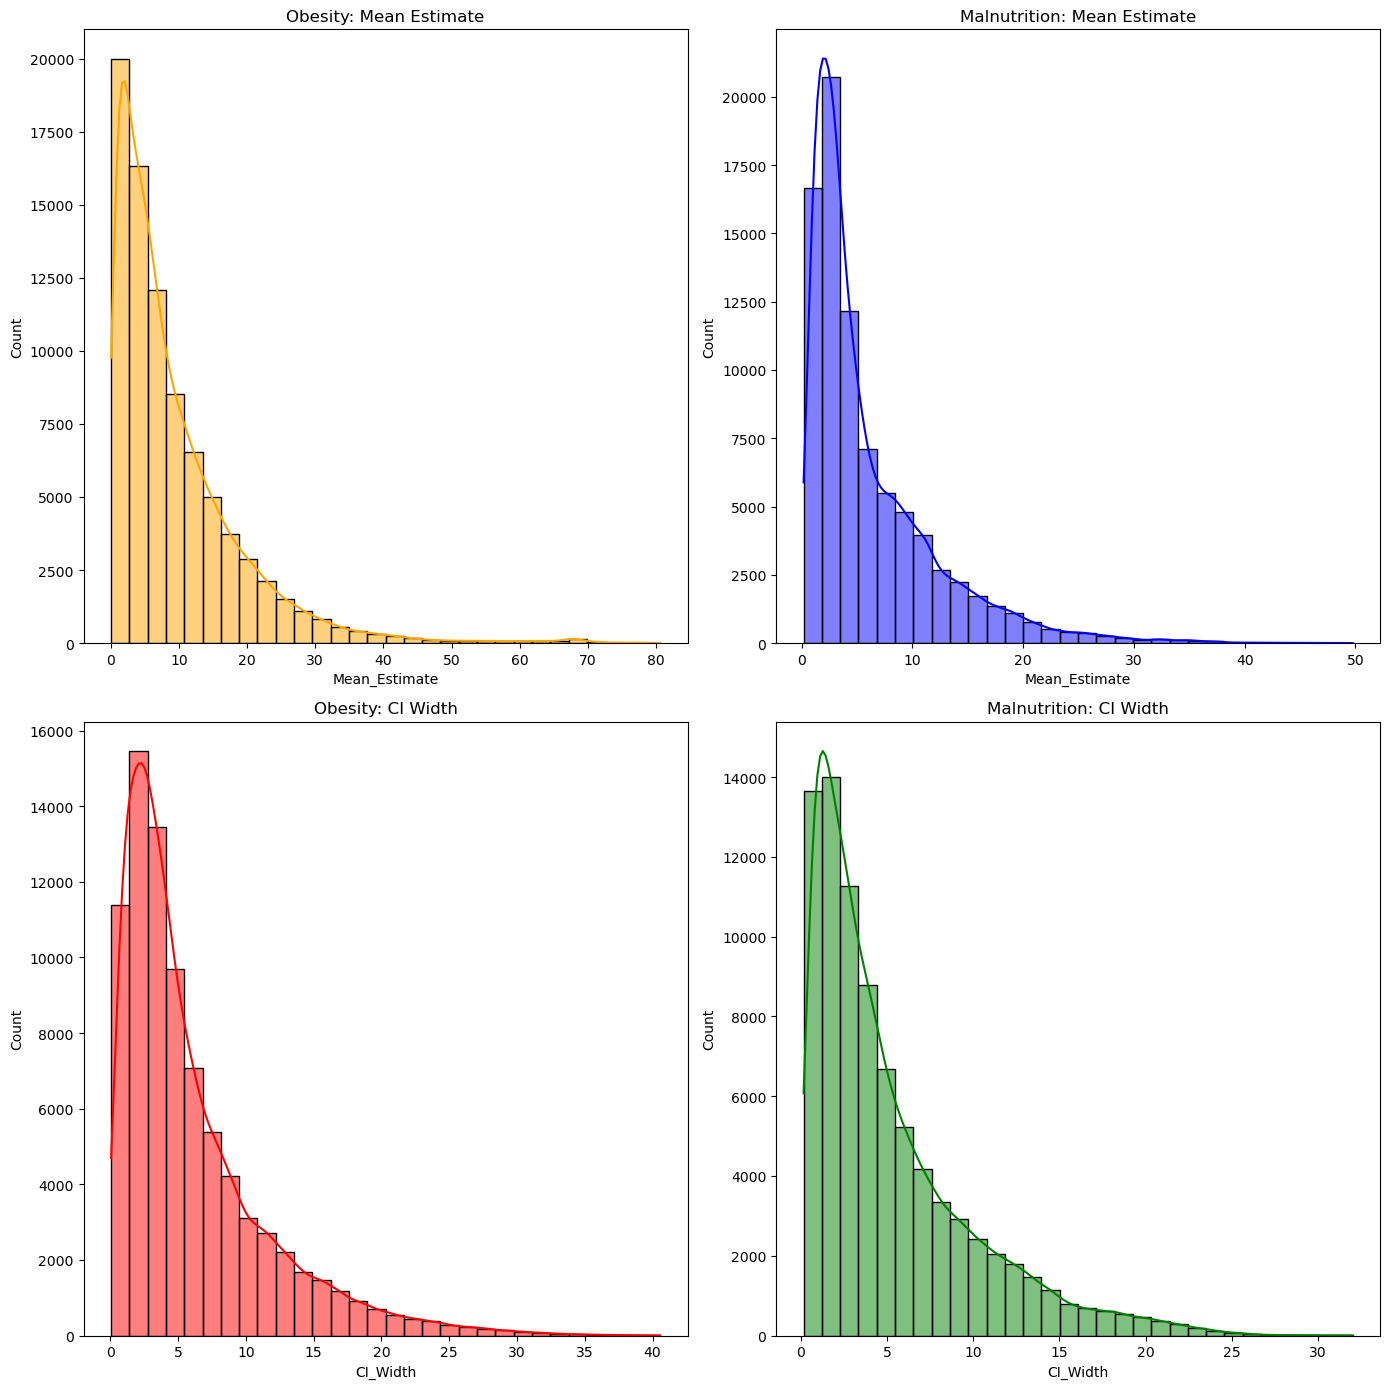

In [24]:
# Distribution of Mean_Estimate and CI_Width

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
sns.histplot(df_obesity['Mean_Estimate'], bins = 30, ax = axes[0,0], kde = True, color = 'Orange')
axes[0,0].set_title("Obesity: Mean Estimate")

sns.histplot(df_malnutrition['Mean_Estimate'], bins = 30, ax = axes[0,1], kde = True, color = 'blue')
axes[0,1].set_title("Malnutrition: Mean Estimate")

sns.histplot(df_obesity['CI_Width'], bins = 30, ax = axes[1,0], kde = True, color = 'red')
axes[1,0].set_title("Obesity: CI Width")

sns.histplot(df_malnutrition['CI_Width'], bins = 30, ax = axes[1,1], kde = True, color = 'green')
axes[1,1].set_title("Malnutrition: CI Width")

plt.tight_layout()
plt.show()

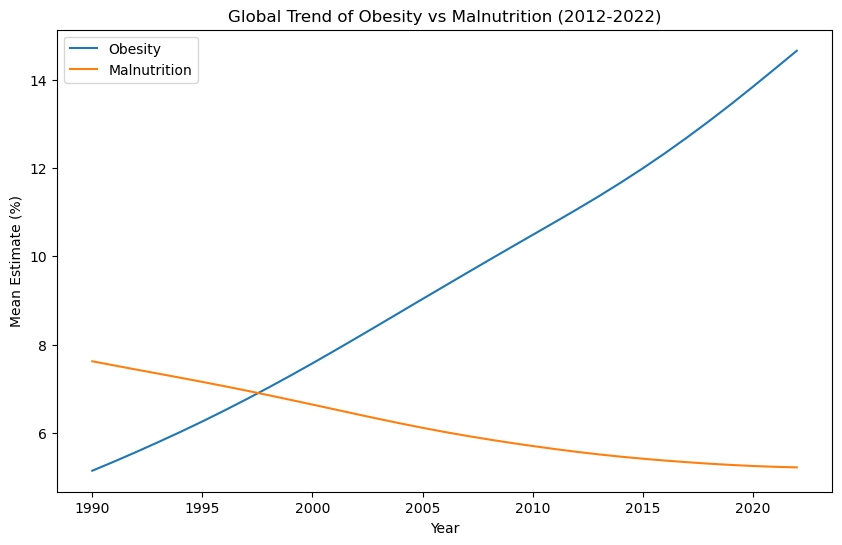

In [25]:
# Average Mean Estimate Per Year

plt.figure(figsize=(10,6))
sns.lineplot(data = df_obesity, x = 'Year', y = 'Mean_Estimate', label = 'Obesity', errorbar = None)
sns.lineplot(data = df_malnutrition, x = 'Year', y = 'Mean_Estimate', label = 'Malnutrition', errorbar = None)
plt.title("Global Trend of Obesity vs Malnutrition (2012-2022)")
plt.ylabel("Mean Estimate (%)")
plt.legend()
plt.show()

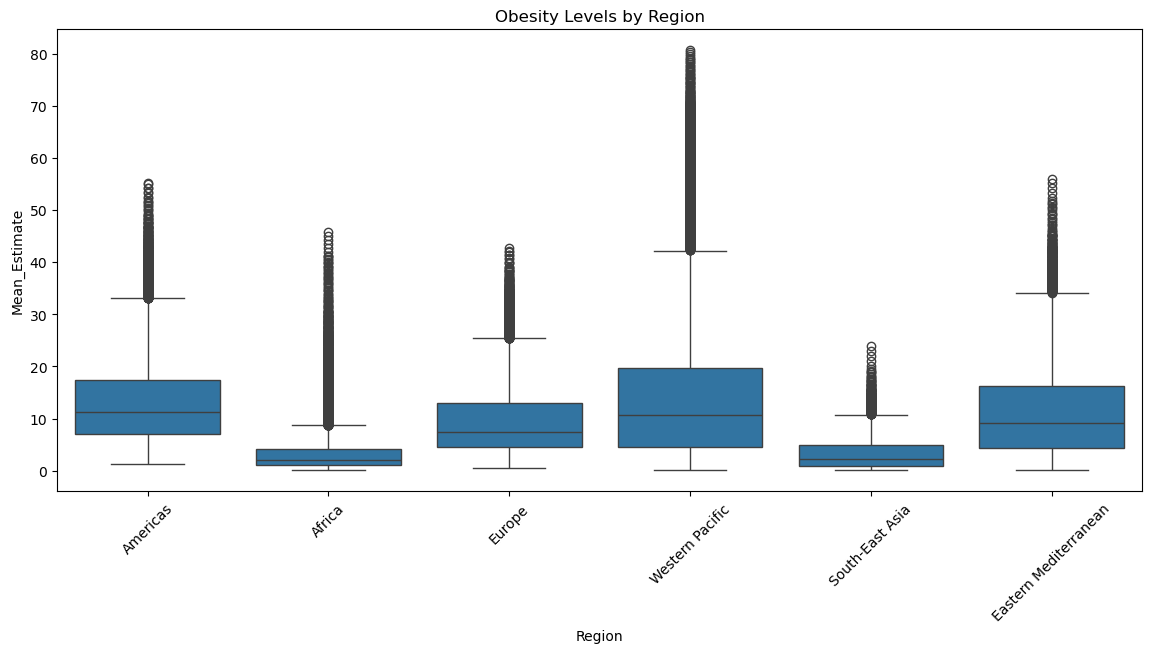

In [26]:
# Boxplot of obesity by region
plt.figure(figsize=(14,6))
sns.boxplot(data = df_obesity, x = 'Region', y = 'Mean_Estimate')
plt.title("Obesity Levels by Region")
plt.xticks(rotation = 45)
plt.show()

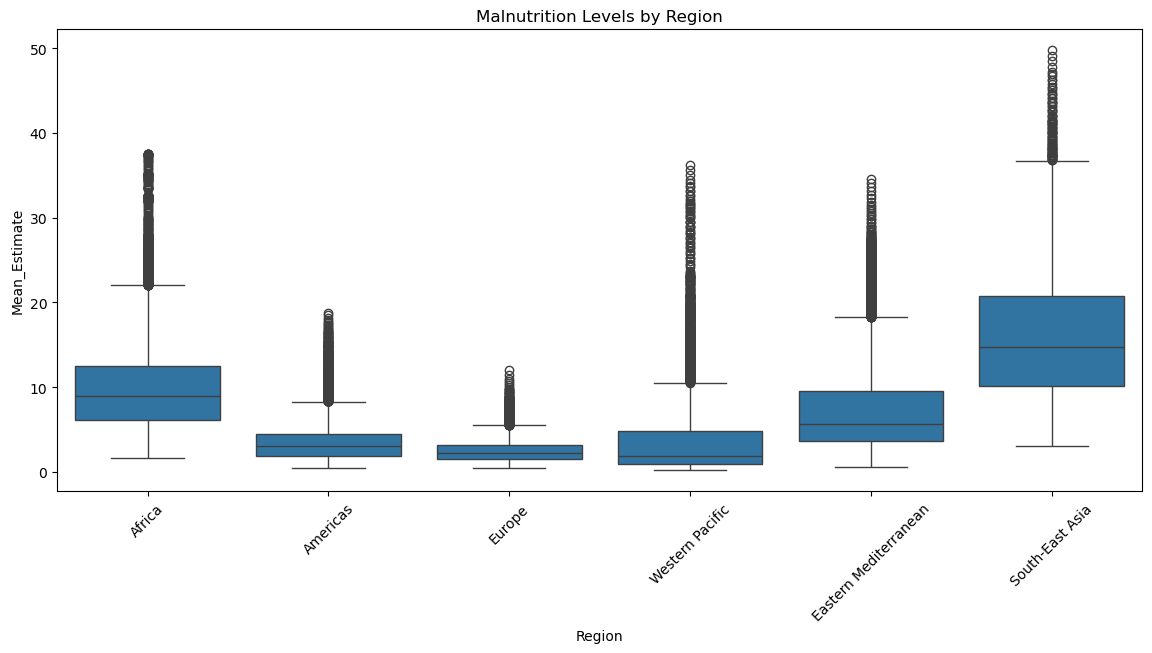

In [27]:
# Boxplot of malnutrition by region
plt.figure(figsize=(14,6))
sns.boxplot(data = df_malnutrition, x = 'Region', y = 'Mean_Estimate')
plt.title("Malnutrition Levels by Region")
plt.xticks(rotation = 45)
plt.show()

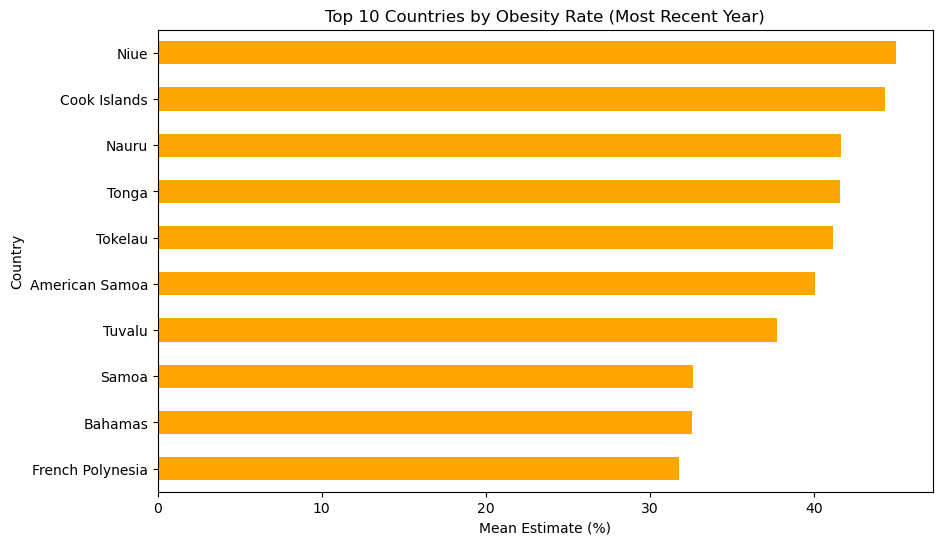

In [28]:
# Top 10 obesity countries (most recent year)

latest_obesity = df_obesity[df_obesity['Year'] == df_obesity['Year'].max()]
top10_obesity = latest_obesity.groupby('Country')['Mean_Estimate'].mean().sort_values(ascending = False).head(10)

# Plotting top10_obesity
plt.figure(figsize=(10,6))
top10_obesity.plot(kind='barh',color='orange')
plt.gca().invert_yaxis()
plt.title("Top 10 Countries by Obesity Rate (Most Recent Year)")
plt.xlabel("Mean Estimate (%)")
plt.show()

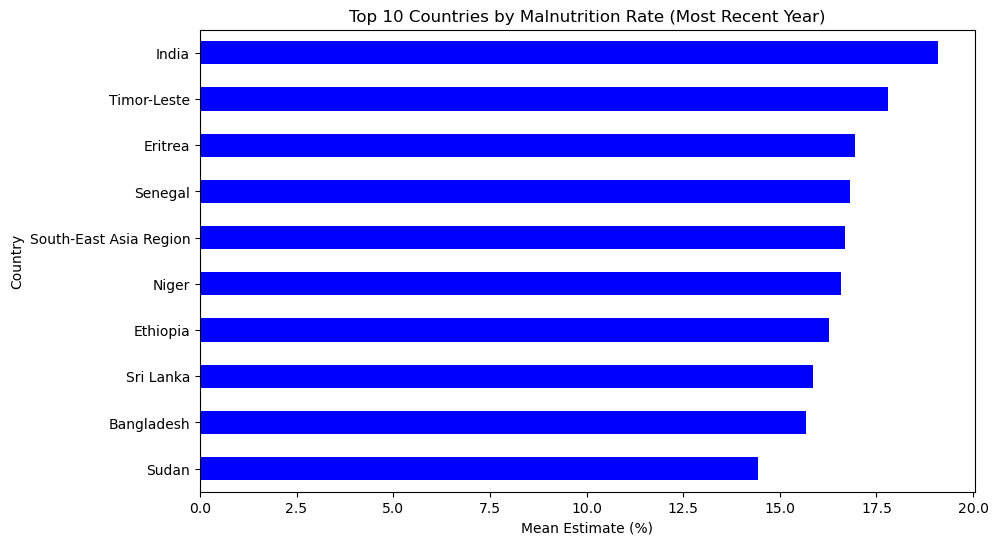

In [29]:
# Bottom 10 Malnutrition Countries (Most Recent Year)

latest_malnutrition = df_malnutrition[df_malnutrition['Year'] == df_malnutrition['Year'].max()]
top10_malnutrition = latest_malnutrition.groupby('Country')['Mean_Estimate'].mean().sort_values(ascending = False).head(10)

plt.figure(figsize=(10,6))
top10_malnutrition.plot(kind='barh',color='blue')
plt.gca().invert_yaxis()
plt.title("Top 10 Countries by Malnutrition Rate (Most Recent Year)")
plt.xlabel("Mean Estimate (%)")
plt.show()

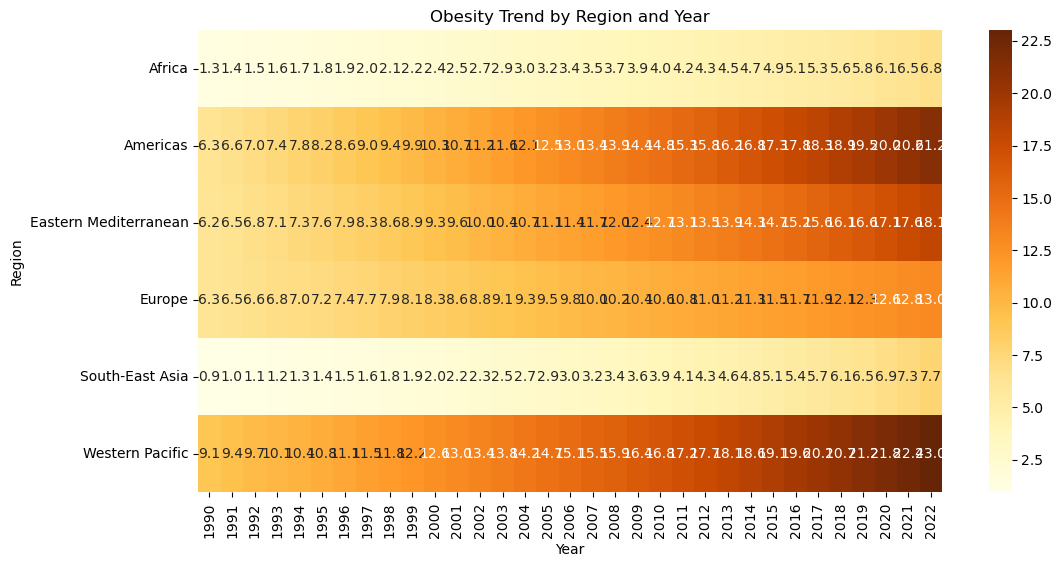

In [30]:
# Heatmap of Obesity by Region and Year
heatmap_data = df_obesity.groupby(['Region','Year'])['Mean_Estimate'].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="YlOrBr", annot=True, fmt=".1f")
plt.title("Obesity Trend by Region and Year")
plt.show()

# Mysql Connection Establish

In [32]:
conn = db.connect(
    host = 'localhost',
    user = 'root',
    password = 'root@123',
    database = 'nutrition_data'
)

In [33]:
# create a cursor object

cursor = conn.cursor()

In [34]:
# Create Obesity Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS obesity (
Year INTEGER,
Gender TEXT,
Mean_Estimate FLOAT,
LowerBound FLOAT,
UpperBound FLOAT,
Age_Group TEXT,
Country TEXT,
Region TEXT,
CI_Width FLOAT,
Obesity_Level TEXT
);
""")

In [35]:
# Create Malnutrition Table
cursor.execute("""
CREATE TABLE IF NOT EXISTS malnutrition (
Year INTEGER,
Gender TEXT,
Mean_Estimate FLOAT,
LowerBound FLOAT,
UpperBound FLOAT,
Age_Group TEXT,
Country TEXT,
Region TEXT,
CI_Width FLOAT,
Obesity_Level TEXT
);
""")
conn.commit()

In [36]:
# Insert Datas into tables

# Insert Obesity Data
for _,row in df_obesity.iterrows():
    cursor.execute("""
    INSERT INTO obesity (Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,Age_Group,CI_Width,Obesity_Level) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """,tuple(row))

# Insert Malnutrition Data
for _,row in df_malnutrition.iterrows():
    cursor.execute("""
    INSERT INTO malnutrition (Region,Gender,Year,LowerBound,UpperBound,Mean_Estimate,Country,Age_Group,CI_Width,Obesity_Level) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    """,tuple(row))

conn.commit()
conn.close()
cursor.close()

True

# 1. Project Objective and Usecases Recap

In [10]:
# Goal: 

        # To monitor global nutritional risk by analyzing obesity and malnutrition data across countries, regions, genders, and age groups using WHO APIs.

In [11]:
# Business Use Cases:

        # Identify high-risk regions for obesity or malnutrition.
        # Analyze demographic disparities.
        # Support data-driven public health policies.
        # Enable comparative regional analysis.
        # Report insights via interactive dashboards.

In [18]:
# 2. Data Cleaning & Preparation Summary
# Data Sources: 4 WHO API datasets for:

        # Adult obesity (NCD_BMI_30C)
        
        # Child obesity (NCD_BMI_PLUS2C)
        
        # Adult underweight (NCD_BMI_18C)
        
        # Child thinness (NCD_BMI_MINUS2C)

In [19]:
# Key Steps:

        # Merged adult & child datasets into df_obesity and df_malnutrition.
        
        # Filtered for years 2012–2022.
        
        # Standardized columns & gender labels.
        
        # Converted country codes using pycountry & special cases dict.
        
        # Engineered features:
        
        # age_group, CI_Width, obesity_level, malnutrition_level

In [20]:
# 3. Data Analysis & Visualizations Summary
# Python EDA Highlights:
        # Line plots for global trends.

        # Box plots showing variability in different regions.
        
        # Scatter plots comparing obesity vs malnutrition levels.
        
        # Bar charts showing top/bottom affected countries.

In [21]:
# 4. Key Insights & Findings:
#Global & Regional
        # Highest obesity observed in North America and parts of the Middle East.
        
        # Highest malnutrition observed in Sub-Saharan Africa and South Asia.
        
        # CI_Width higher in low-income regions → lower data reliability.

In [23]:
# Demographics:
        # Children in low-income countries most at risk of malnutrition.
        
        # Adult females in developed countries show higher obesity prevalence.
        
        # Both sexes in developing regions show co-existing malnutrition & rising obesity.

# Time Trends:
        # Obesity is rising steadily worldwide, even in previously low-risk regions.
        
        # Some countries show declining malnutrition, but improvements are uneven.

In [24]:
# 5. Recommendations & Public Health Suggestions

In [25]:
# | Recommendation                                                   | Rationale                                           |
# | ---------------------------------------------------------------- | --------------------------------------------------- |
# | 🎯 **Target South Asia & Africa for malnutrition interventions** | Consistently high undernourishment rates            |
# | 📈 **Monitor emerging obesity in developing countries**          | Obesity is no longer exclusive to developed regions |
# | ⚖️ **Design gender-specific interventions**                      | Notable disparities exist between males and females |
# | 🔬 **Improve data collection in low-income regions**             | High CI\_Width values signal low reliability        |
# | 🧒 **Double focus on children**                                  | Vulnerable to both extremes—obesity & malnutrition  |
# | 📊 **Use dashboards for real-time public health monitoring**     | Enables fast, visual decision-making                |

In [27]:
# Final Wrap-Up:
        # Collected & cleaned multi-dimensional WHO data.

        # Conducted deep EDA with Python visualizations.
        
        # Stored and queried data via MySQL.
        
        # Built a Power BI dashboard for stakeholder communication.
        
        # Extracted insights to drive evidence-based public health decisions.